# Nb-20180319-0916-RandomForest-GainPrediction

In [1]:
STAMP = "20180319-0916"

This is a modification of the previous notebook.

**Fixed error in calculating the value of the dependent variable, 'Gain 1d'. **

Do a simple random forest to try to predict if a stock ticker will make a gain the next day.


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from collections import defaultdict
import operator

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [5]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [6]:
import finance as fat

In [7]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [8]:
tickers = ['AAPL', 'FB', 'IBM', 'GOOG', 'MSFT']

In [9]:
def create_ml_ticker_features_df(ticker) :
    data = fat.get_price_data(ticker)
    
    # check for required columns in data
    for c in ['Open','High','Low','Close','Adj Close', 'Volume'] :
        assert c in data.columns, f'{ticker} does not contain data for {c}'
    
    # Price features
    data = adjust_ohlc_prices(data)
    data = add_history(data, 'Adj Close', range(-5, 0))
    data = fat.add_sma_columns(data, 'Adj Close', [6,12,20,200])
    data = fat.add_ema_columns(data, 'Adj Close', [3,6,12,26,50])
    data = fat.add_bollinger_bands(data, 'Adj Close')
    data = scale_columns(data, 1.0/data['Adj Close'], column_contains='Adj')
    # 'Adj Close' data has all been scaled to 1.0, so get rid of it
    del data['Adj Close']
    # data = add_ohlc_booleans(data)
    
    # Volume features
    # ... first, replace 0's with 1's so we don't divide by zero when scaling (some data has 0's in volume)
    data['Volume'] = data['Volume'].replace(0, 1)
    data = add_history(data, 'Volume', range(-5, 0))
    data = scale_columns(data, 1.0/data['Volume'], column_contains='Volume')
    # 'Volume' data has all been scaled to 1.0, so get rid of it
    del data['Volume']
    
    return data

In [10]:
def adjust_ohlc_prices(data_frame, inplace=False) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    
    df = fat.use_data_frame_if_inplace(data_frame, inplace)
    
    columns = ['Open', 'High', 'Low', 'Close']
    scaling = df['Close'] / df['Adj Close']
    for c in columns :
        df[c] /= scaling
    
    del df['Adj Close']
    
    # rename columns, add 'Adj ' to name
    new_cols = {c : ('Adj '+c) for c in columns}
    df.rename(columns=new_cols, inplace=True)
    return df

In [11]:
def add_history(data_frame, column, day_range, inplace=False) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    df = fat.use_data_frame_if_inplace(data_frame, inplace)
    
    for i in day_range :
        df[f'{column} {i}d'] = df[column].shift(-i)
    return df

In [12]:
def scale_columns(data_frame, scaling, column_contains, inplace=False) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    df = fat.use_data_frame_if_inplace(data_frame, inplace)
    
    for c in df.columns : 
        if column_contains in c :
            df[c] *= scaling
    return df

In [13]:
def add_ticker(data_frame, ticker) :
    assert isinstance(data_frame, pd.DataFrame), \
        "data_frame must be pandas.DataFrame object"
    df = data_frame.copy()
    
    df['Ticker'] = ticker
    
    # ... and rearrange columns to put ticker in front 
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

In [14]:
data_raw = None
for t in tickers :
    df = create_ml_ticker_features_df(t)
    df = fat.create_ml_features_df(df)
    df = add_ticker(df, t)
    
    df['Gain +1d'] = df['Adj Close -1d'].shift(-1) < 1.0
    
    data_raw = df.append(data_raw)        

Could not load updates for AAPL from yahoo. Using cached data.
Loaded data for AAPL: 1980-12-12 to 2018-03-16.
Could not load updates for FB from yahoo. Using cached data.
Loaded data for FB: 2012-05-18 to 2018-03-16.
Could not load updates for IBM from yahoo. Using cached data.
Loaded data for IBM: 1970-01-02 to 2018-03-16.
Could not load updates for GOOG from yahoo. Using cached data.
Loaded data for GOOG: 2004-08-19 to 2018-03-16.
Could not load updates for MSFT from yahoo. Using cached data.
Loaded data for MSFT: 1986-03-13 to 2018-03-16.


In [15]:
data_raw.tail()

,Ticker,Adj Open,Adj High,Adj Low,Adj Close -5d,Adj Close -4d,Adj Close -3d,Adj Close -2d,Adj Close -1d,Adj Close SMA6,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-12,AAPL,0.992131,1.003687,0.991691,0.973035,0.972210,0.963185,0.973696,0.990425,0.978759,...,0,71,False,False,False,False,False,False,1520812800,False
2018-03-13,AAPL,1.014558,1.019614,0.995944,0.981664,0.972551,0.983164,1.000056,1.009724,0.991193,...,1,72,False,False,False,False,False,False,1520899200,False
2018-03-14,AAPL,1.010536,1.011657,0.996469,0.980890,0.991594,1.008630,1.018382,1.008574,1.001345,...,2,73,False,False,False,False,False,False,1520985600,True
2018-03-15,AAPL,0.999160,1.008900,0.996754,0.990428,1.007445,1.017184,1.007389,0.998825,1.003545,...,3,74,False,False,False,False,False,False,1521072000,False
2018-03-16,AAPL,1.003539,1.006179,0.997753,1.011010,1.020784,1.010954,1.002359,1.003539,1.008108,...,4,75,False,False,False,False,False,False,1521158400,False


In [16]:
data_raw = data_raw.sort_index()
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Open,34511.0,1.000351e+00,3.750595e-02,8.384615e-01,9.913874e-01,1.000000e+00,1.008768e+00,7.057778e+00
Adj High,34511.0,1.012602e+00,3.558246e-02,1.000000e+00,1.003832e+00,1.008427e+00,1.016396e+00,7.111111e+00
Adj Low,34511.0,9.877507e-01,1.306389e-02,7.788786e-01,9.836227e-01,9.915825e-01,9.962808e-01,1.000000e+00
Adj Close -5d,34486.0,9.975326e-01,5.094059e-02,5.995718e-01,9.727023e-01,9.965232e-01,1.020520e+00,2.424929e+00
Adj Close -4d,34491.0,9.980339e-01,4.559276e-02,6.573880e-01,9.758057e-01,9.975034e-01,1.018661e+00,2.264551e+00
Adj Close -3d,34496.0,9.985408e-01,3.981539e-02,6.766591e-01,9.797783e-01,9.980713e-01,1.016237e+00,2.397760e+00
Adj Close -2d,34501.0,9.990359e-01,3.258341e-02,6.766591e-01,9.839441e-01,9.989432e-01,1.013433e+00,2.206186e+00
Adj Close -1d,34506.0,9.995164e-01,2.292707e-02,7.505934e-01,9.893387e-01,1.000000e+00,1.009462e+00,2.077671e+00
Adj Close SMA6,34486.0,9.987715e-01,2.819414e-02,7.519628e-01,9.852557e-01,9.983733e-01,1.011191e+00,1.846683e+00
Adj Close SMA12,34456.0,9.972816e-01,4.297491e-02,6.572091e-01,9.758976e-01,9.960532e-01,1.016232e+00,2.129611e+00


In [17]:
data_raw.tail().T

Date,2018-03-16 00:00:00,2018-03-16 00:00:00,2018-03-16 00:00:00,2018-03-16 00:00:00,2018-03-16 00:00:00
Ticker,GOOG,MSFT,FB,IBM,AAPL
Adj Open,1.01621,1.00085,0.996758,0.998752,1.00354
Adj High,1.01774,1.00825,1.0013,1.01073,1.00618
Adj Low,0.996681,0.992812,0.990923,0.996131,0.997753
Adj Close -5d,1.0214,1.02051,1.00076,0.994072,1.01101
Adj Close -4d,1.02533,1.02294,0.998217,1,1.02078
Adj Close -3d,1.00215,0.997992,0.982657,0.994135,1.01095
Adj Close -2d,1.01212,0.992072,0.995138,0.986647,1.00236
Adj Close -1d,1.01219,0.99556,0.993355,0.995944,1.00354
Adj Close SMA6,1.0122,1.00484,0.99502,0.995133,1.00811


In [18]:
data_raw = data_raw.dropna()
data_raw.head().T

Date,1970-10-14 00:00:00,1970-10-15 00:00:00,1970-10-16 00:00:00,1970-10-19 00:00:00,1970-10-20 00:00:00
Ticker,IBM,IBM,IBM,IBM,IBM
Adj Open,1.00172,0.994881,1.00774,1.00791,0.977243
Adj High,1.01115,1.0064,1.00946,1.00791,1.00301
Adj Low,0.995712,0.994881,0.99742,0.994728,0.977243
Adj Close -5d,1.04889,1.01792,1.01849,1.02021,1.00301
Adj Close -4d,1.02316,1.01067,0.998281,1.02636,1.00129
Adj Close -3d,1.01587,0.990615,1.0043,1.0246,1.00644
Adj Close -2d,0.995712,0.996587,1.00258,1.02988,0.998712
Adj Close -1d,1.00171,0.994881,1.00774,1.02197,0.977244
Adj Close SMA6,1.01422,1.00178,1.00523,1.0205,0.997782


In [19]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Open,33516.0,1.000335e+00,3.789003e-02,8.384615e-01,9.913839e-01,1.000000e+00,1.008726e+00,7.057778e+00
Adj High,33516.0,1.012555e+00,3.601648e-02,1.000000e+00,1.003775e+00,1.008403e+00,1.016332e+00,7.111111e+00
Adj Low,33516.0,9.877496e-01,1.299882e-02,7.788786e-01,9.836885e-01,9.915617e-01,9.962124e-01,1.000000e+00
Adj Close -5d,33516.0,9.974619e-01,5.011002e-02,5.995718e-01,9.729368e-01,9.964481e-01,1.020060e+00,2.424929e+00
Adj Close -4d,33516.0,9.979770e-01,4.487780e-02,6.573880e-01,9.761354e-01,9.974534e-01,1.018342e+00,2.264551e+00
Adj Close -3d,33516.0,9.984963e-01,3.924750e-02,6.766591e-01,9.799794e-01,9.980365e-01,1.015883e+00,2.397760e+00
Adj Close -2d,33516.0,9.990020e-01,3.215202e-02,6.766591e-01,9.841103e-01,9.989295e-01,1.013215e+00,2.206186e+00
Adj Close -1d,33516.0,9.995008e-01,2.270671e-02,7.505934e-01,9.894212e-01,1.000000e+00,1.009344e+00,2.077671e+00
Adj Close SMA6,33516.0,9.987397e-01,2.776226e-02,7.519628e-01,9.854205e-01,9.983208e-01,1.010961e+00,1.846683e+00
Adj Close SMA12,33516.0,9.972216e-01,4.239042e-02,6.572091e-01,9.761041e-01,9.959932e-01,1.015922e+00,2.129611e+00


In [20]:
del data_raw['Elapsed']
del data_raw['Year']

In [21]:
train_cats(data_raw)
data_raw.head().T

Date,1970-10-14 00:00:00,1970-10-15 00:00:00,1970-10-16 00:00:00,1970-10-19 00:00:00,1970-10-20 00:00:00
Ticker,IBM,IBM,IBM,IBM,IBM
Adj Open,1.00172,0.994881,1.00774,1.00791,0.977243
Adj High,1.01115,1.0064,1.00946,1.00791,1.00301
Adj Low,0.995712,0.994881,0.99742,0.994728,0.977243
Adj Close -5d,1.04889,1.01792,1.01849,1.02021,1.00301
Adj Close -4d,1.02316,1.01067,0.998281,1.02636,1.00129
Adj Close -3d,1.01587,0.990615,1.0043,1.0246,1.00644
Adj Close -2d,0.995712,0.996587,1.00258,1.02988,0.998712
Adj Close -1d,1.00171,0.994881,1.00774,1.02197,0.977244
Adj Close SMA6,1.01422,1.00178,1.00523,1.0205,0.997782


But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [22]:
file_name = f'data/tmp/{STAMP}-gain-raw'

In [23]:
os.makedirs('data/tmp', exist_ok=True)
data_raw = data_raw.reset_index()
data_raw.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [24]:
df_raw = pd.read_feather(file_name)

In [25]:
df_raw = df_raw.set_index('Date')
df_raw.index

DatetimeIndex(['1970-10-14', '1970-10-15', '1970-10-16', '1970-10-19',
               '1970-10-20', '1970-10-21', '1970-10-22', '1970-10-23',
               '1970-10-26', '1970-10-27',
               ...
               '2018-03-15', '2018-03-15', '2018-03-15', '2018-03-15',
               '2018-03-15', '2018-03-16', '2018-03-16', '2018-03-16',
               '2018-03-16', '2018-03-16'],
              dtype='datetime64[ns]', name='Date', length=33516, freq=None)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [26]:
dep_col = 'Gain +1d'

In [27]:
df, y, nas = proc_df(df_raw, dep_col)

In [28]:
train_end = '2016-02'
valid_start = '2016-03'
valid_end = '2017-02'
test_start = '2017-03'

In [29]:
df_train = df[:train_end]
df_valid = df[valid_start : valid_end]
df_test = df[test_start:]
print(f'train, valid, test sizes: {len(df_train)}, {len(df_valid)}, {len(df_test)}')

train, valid, test sizes: 30936, 1260, 1320


In [30]:
X_train = df_train
X_valid = df_valid
X_test = df_test
print(f'train, valid, test sizes: {len(X_train)}, {len(X_valid)}, {len(X_test)}')

train, valid, test sizes: 30936, 1260, 1320


In [31]:
y, train_end

(array([ True, False, False, ..., False, False, False]), '2016-02')

In [32]:
y_train = y[:len(X_train)]
y_valid = y[len(X_train)+1 : -len(X_test)+1]
y_test = y[-len(X_test):]
print(f'train, valid, test sizes: {len(y_train)}, {len(y_valid)}, {len(y_test)}')

train, valid, test sizes: 30936, 1260, 1320


# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [33]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [34]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_features='log2', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.9111714507370055, 0.5063492063492063, 0.5257951900698216]


In [35]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[320, 256],
       [366, 318]], dtype=int64)

In [36]:
def plot_metrics(metrics): return metrics.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [37]:
def get_metrics(stamp, y_valid, y_pred, chance) :
    col = ['accuracy', 'precision','recall','f1','chance']
    val = []
    val.append(metrics.accuracy_score(y_valid, y_pred))
    val.append(metrics.precision_score(y_valid, y_pred))
    val.append(metrics.recall_score(y_valid, y_pred))
    val.append(metrics.f1_score(y_valid, y_pred))
    val.append(chance)
    
    return pd.DataFrame(data=[val], columns=col, index=[stamp])

In [38]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
chance = cnf_matrix[1:].sum() / cnf_matrix.sum()

In [39]:
met = get_metrics(STAMP, y_valid, y_pred, chance)

,accuracy,precision,recall,f1,chance
20180319-0916,0.506349,0.554007,0.464912,0.505564,0.542857


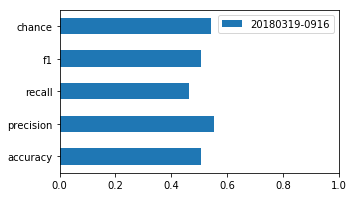

In [40]:
met.T.plot(kind='barh', figsize=(5,3), xlim=(0,1))
met

In [41]:
fi = rf_feat_importance(m, df)

In [42]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

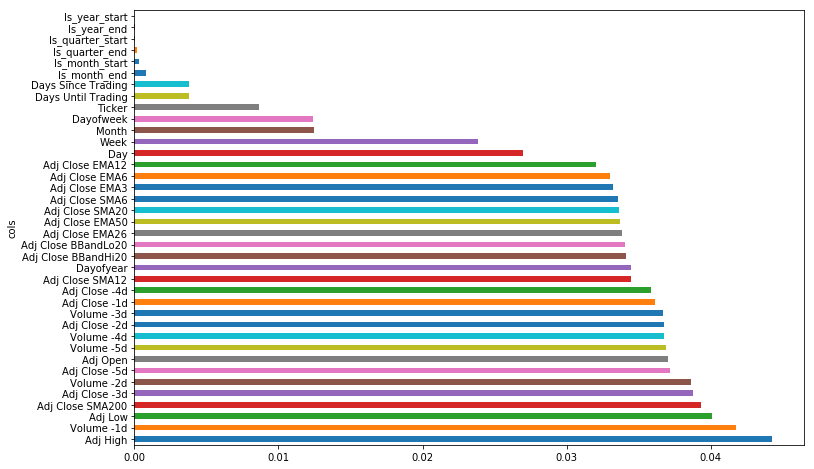

In [43]:
plot_fi(fi)

### Confidence

In [44]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.47 s


(0.41, 0.49183330509431744)

In [45]:
x = df_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [46]:
x['Gain +1d'] = y_valid

In [47]:
conf_gain = x.loc[x['pred'] >= 0.7]
conf_gain = pd.DataFrame(conf_gain, columns=['Ticker','pred','pred_std', 'Gain +1d'])
print(f"{len(conf_gain)} {len(conf_gain.loc[conf_gain['Gain +1d'] == True])/len(conf_gain)}")

14 0.6428571428571429


In [51]:
conf_gain

,Ticker,pred,pred_std,Gain +1d
Date,,,,
2016-03-31,4,0.72,0.448999,True
2016-04-01,2,0.74,0.438634,False
2016-04-01,1,0.72,0.448999,False
2016-04-04,1,0.70,0.458258,False
2016-04-28,3,0.74,0.438634,True
2016-05-03,5,0.72,0.448999,False
2016-05-06,2,0.70,0.458258,True
2016-07-15,4,0.74,0.438634,True
2016-08-05,5,0.73,0.443959,False
